In [1]:
!pip install d2l==1.0.0-alpha1.post0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.8 MB/s eta 0:00:00


In [2]:
from d2l import torch as d2l

In [3]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pylab as plt

In [4]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils

# Parameter Settings



In [6]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 40
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

# # 10-d latent space, for comparison with non-variational auto-encoder
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

# MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [7]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 80235968.34it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11046479.47it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26222482.82it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20223491.26it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



# Auto Encoders

On va commencer par explorer la construction d'un auto-encodeur pour représenter nos données MNIST. 


## Définitions du réseau de neurones 

On va définir deux structures : un encodeur et un décodeurs

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    

Un auto-encodeur est simplement la conjonction de l'encodeur et du décodeur

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon, latent

## Boucles d'apprentissage

In [10]:
def ae_loss(recon_x, x):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    return recon_loss

In [11]:
def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs capabilities"""
    # on met notre batch de donnée sur la cible de calcul
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    # on met notre reseau en mode 'train'
    net.train()
    # on initialise le gradient a zéro
    trainer.zero_grad()
    # on fait la prediction
    pred = net(X)[0]
    # on calcul la lfonction de perte 
    l = loss(pred, X)
    # on fait la rétro-propagation du gradient
    l.sum().backward()
    # on informe la descente de gradient qu'on veut faire un pas dans la descente
    trainer.step()
    # on sauvegarde les informations sur les prédiction en train
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, X)
    return train_loss_sum, train_acc_sum

In [12]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Trainning loop
    
    net : le reseau de neuronnes 
    train_iter : le dataloder train
    test_iter : le dataloader test
    loss : la fonction de cout choisi
    trainner : l'optimiseur choisi
    num_epoch : le nombre d'époch 
     """
    timer, num_batches = d2l.Timer(), len(train_iter)

    # plot annimation
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    
    # declare network for multiple GPU :
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            
            # do one batch : 
            l, acc = train_batch(
                net, features, labels, loss, trainer, devices)
            
            # on divise arbitrairement la loss par 200 pour l'affichage
            metric.add(l/200, acc, labels.shape[0], labels.numel())
            timer.stop()
            
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        # fin d'époch -> calcul perf en test
        test_acc = 0
        acc = 0
        net.eval()
        for Xt, yt in test_iter:
            if isinstance(Xt, list):
                Xt = [x.to(devices[0]) for x in Xt]
            else:
                Xt = Xt.to(devices[0])
            # on met notre reseau en mode 'train'
            net.train()
            # on initialise le gradient a zéro
            trainer.zero_grad()
            # on fait la prediction
            pred = net(Xt)[0]
            test_acc += d2l.accuracy(pred, Xt)
            acc += Xt.shape[0]
        test_acc = test_acc / acc

        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

## Apprentissage

In [13]:
ae = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
ae = ae.to(device)

num_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 295811


In [14]:
optimizer = torch.optim.Adam(params=ae.parameters(), lr=learning_rate, weight_decay=1e-5)

loss 0.691, train acc 0.000, test acc 0.000
36103.8 examples/sec on [device(type='cuda', index=0)]


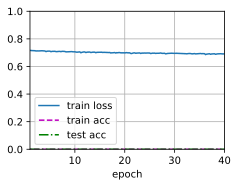

In [17]:
train(ae, train_dataloader, test_dataloader , ae_loss, optimizer, num_epochs)

In [18]:
!nvidia-smi

Tue May 16 12:10:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |   1404MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Affichage de l'espace lattent 

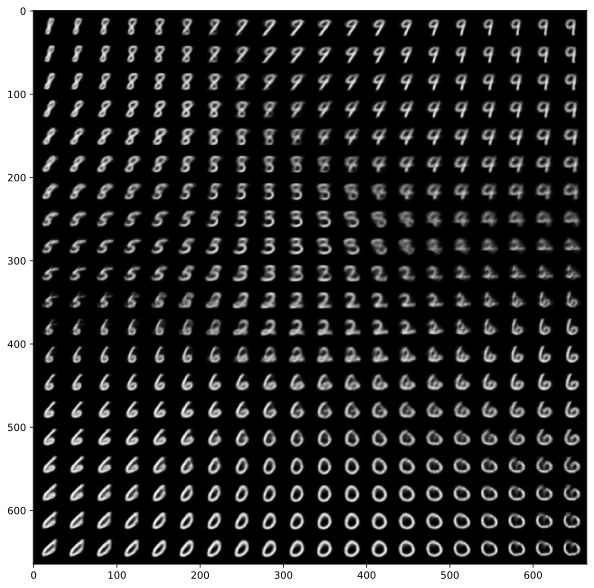

In [19]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = ae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

## interpolation dans l'espace lattent 

In [20]:
ae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)
        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    

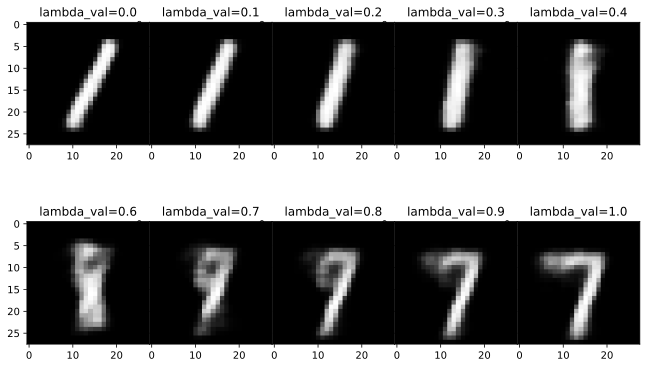

In [21]:
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(11, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), ae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))


Variational Autoencoders (VAEs)
======


Le VAE mis en œuvre ici utilise la configuration trouvée dans la plupart des articles sur les VAE : une distribution normale multivariée pour la distribution conditionnelle des vecteurs latents étant donné une image en entrée ($q_{\phi}(z | x_i)$) et une distribution de Bernoulli multivariée pour la distribution conditionnelle des images étant donné le vecteur latent ($p_{\theta}(x | z)$). En utilisant une distribution de Bernoulli, la loss de reconstruction (log-vraisemblance négative d'un point de données dans la distribution de sortie) se réduit à l'entropie croisée binaire pixel par pixel. Voir le [document original sur les VAE](https://arxiv.org/pdf/1312.6114.pdf), Annexe C.1 pour plus de détails.

VAE Definition
-----------------------
Nous utilisons un encodeur et un décodeur convolutionnels, ce qui donne généralement de meilleures performances que les versions fully connected ayant le même nombre de paramètres.

Dans les couches de convolution, nous augmentons les canaux à mesure que nous approchons du goulot d'étranglement, mais notez que le nombre total de paramètres diminue toujours, car les canaux augmentent d'un facteur de 2 à chaque convolution, tandis que la taille spatiale diminue d'un facteur de 4.

La taille du noyau 4 est utilisée pour éviter les problèmes de biais décrits ici : https://distill.pub/2016/deconv-checkerboard/

In [22]:
class EncoderVariationel(nn.Module):
    def __init__(self):
        super(EncoderVariationel, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) 
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

La définition du VAE est simplement d'adjonction de la partie encodeur et décodeur. On remarquera l'astuce de reparamétrisation utiliser pour permettre l'échantillonage alléatoire lors de l'apprentissage :

In [23]:

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = EncoderVariationel()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    

## Définition de la fonction de loss

pour la loss on combine une loss de type cross-entropie entre l'entrée et la sortie et une loss de type KL pour forcer la structure Gaussienne de l'espace lattent :

In [24]:

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    

On doit modifier la prédiction pour pouvoir renvoyer les variables de l'espace latent qui seront réutiliser au niveau de la KL-Divergence

In [25]:
def train_batch_vae(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs capabilities"""
    # on met notre batch de donnée sur la cible de calcul
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    # on met notre reseau en mode 'train'
    net.train()
    # on initialise le gradient a zéro
    trainer.zero_grad()
    # on fait la prediction
    image_batch_recon, latent_mu, latent_logvar = net(X)
    # on calcul la lfonction de perte 
    l = loss(image_batch_recon, X, latent_mu, latent_logvar)
    # on fait la rétro-propagation du gradient
    l.sum().backward()
    # on informe la descente de gradient qu'on veut faire un pas dans la descente
    trainer.step()
    # on sauvegarde les informations sur les prédiction en train
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(image_batch_recon, X)
    return train_loss_sum, train_acc_sum

In [26]:
def train_vae(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Trainning loop
    
    net : le reseau de neuronnes 
    train_iter : le dataloder train
    test_iter : le dataloader test
    loss : la fonction de cout choisi
    trainner : l'optimiseur choisi
    num_epoch : le nombre d'époch 
     """
    timer, num_batches = d2l.Timer(), len(train_iter)

    # plot annimation
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc'])
    
    # declare network for multiple GPU :
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            
            # do one batch : 
            l, acc = train_batch_vae(
                net, features, labels, loss, trainer, devices)
            
            # on divise arbitrairement la loss par 200 pour l'affichage
            metric.add(l/200, acc, labels.shape[0], labels.numel())
            timer.stop()
            
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))

    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

Apprentissage du VAE 
--------

In [27]:
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


In [28]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

31272.4 examples/sec on [device(type='cuda', index=0)]


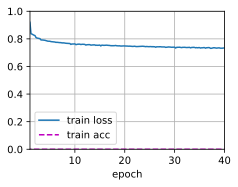

In [29]:
train_vae(vae, train_dataloader, test_dataloader , vae_loss, optimizer, num_epochs)

Visualize Reconstructions
--------------------------

Original images


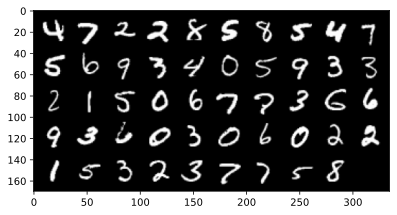

VAE reconstruction:


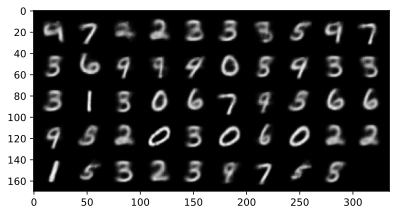

In [34]:
vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate dans l'espace latent 
----------------------------

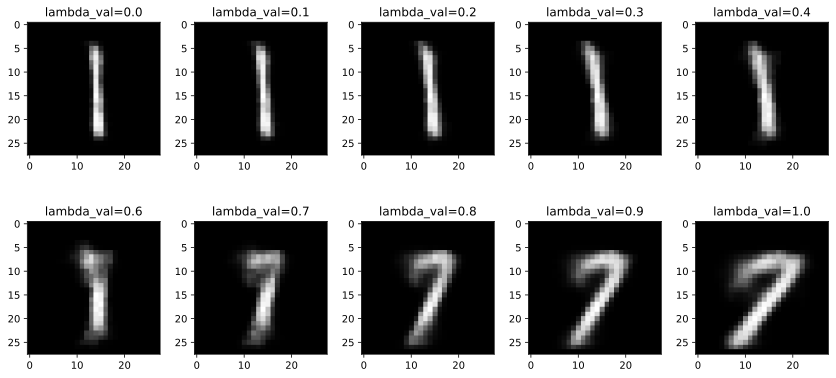

In [35]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

## Utilisation du VAE comme un générateur 

-------------------------------------------------

Un VAE peut générer de nouveaux chiffres en tirant des vecteurs latents de la distribution a priori. Bien que les chiffres générés ne soient pas parfaits, ils sont généralement meilleurs que pour un Autoencoder non variationnel (comparez les résultats pour le VAE avec les résultats pour l'autoencoder).

De manière similaire aux autoencoders, le manifold des vecteurs latents qui se décodent en chiffres valides est plus sparse dans des espaces latents de dimension supérieure. Augmenter le poids du terme KL-divergence dans la loss (augmenter `variational_beta`) rend le manifold moins éparse au détriment d'une reconstruction de moindre qualité.

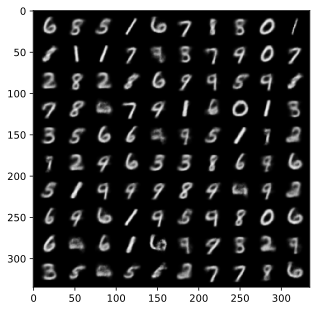

In [36]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

## Affichage 2D de l'espace lattent
---------------------

Le code suivant permet de faire un affichage d'un espace lattent 2D 


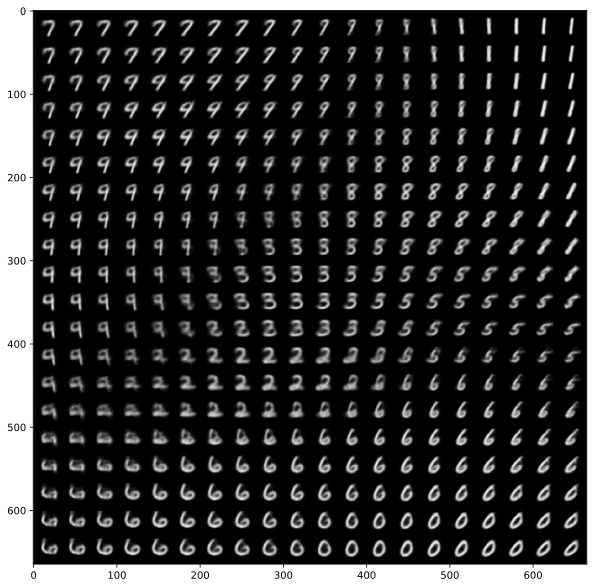

In [37]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

# Exercices 

1. Comparer les AE et VAE
1. tester différentes tailles d'espaces lattent
1. tester l'interpollation dans l'espace latent entre différents chiffres
1. implémenter une version denoising AE ou denoising VAE, pour cela le plus simple est d'encapsuler la classe Dataset de MNIST dans une classe qui renvois a la vois l'image bruité (X) Et l'image non bruité (y)